# Map of sub-domain of ANHA12

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import matplotlib
import pickle

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

isize = imax-imin
jsize = jmax-jmin

# runoff period:
rf_year  = 2010
rf_month = 8    # september 

# Resolution of grid cells to show in figure:
grid_reso = 10

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1600,imax,jmax,jmax) # Northern Canada Basin
bdy_WCB = (imax,imax,391,jmax)  # Western Canada Basin
bdy_BB  = (imin,imin,449,674)   # Baffin Bay
bdy_HB  = (1189,1474,291,291)   # Hudson Bay

# colours:
color_glacier   = '#0873b4'
color_continent = '#d67434' 
color_other     = 'w' #'#515151'
light_land      = '#d0d0cf'
light_land_edge = '#929291'
land_color         = '#a9a7a2'
land_outline_color = '#373736'

#### Load files:

In [3]:
mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = np.array(mesh.variables['hdept'][0])

mask         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = np.array(mask.variables['nav_lon'])
mesh_lat     = np.array(mask.variables['nav_lat'])
mesh_bathy   = np.array(mask.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mask.variables['nav_lev'])

In [4]:
# ANHA12 river runoff forcing:
rf_file = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y{rf_year}.nc','r')
model_lons = np.array(rf_file.variables['nav_lon'])
model_lats = np.array(rf_file.variables['nav_lat'])
model_river= np.array(rf_file.variables['runoff'])
rf = model_river[rf_month]

# Place NaNs where there is no runoff
rf[rf == 0]       = np.nan
model_lons[rf == 0.0] = np.nan
model_lats[rf == 0.0] = np.nan

In [5]:
# River classification file
# 1. Glaciers
# 2. Continental
# 3. Other
ncd         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb-202207-forcing/river_class-202207.nc')
river_class = np.array(ncd.variables['rclass'])

#### Figure:

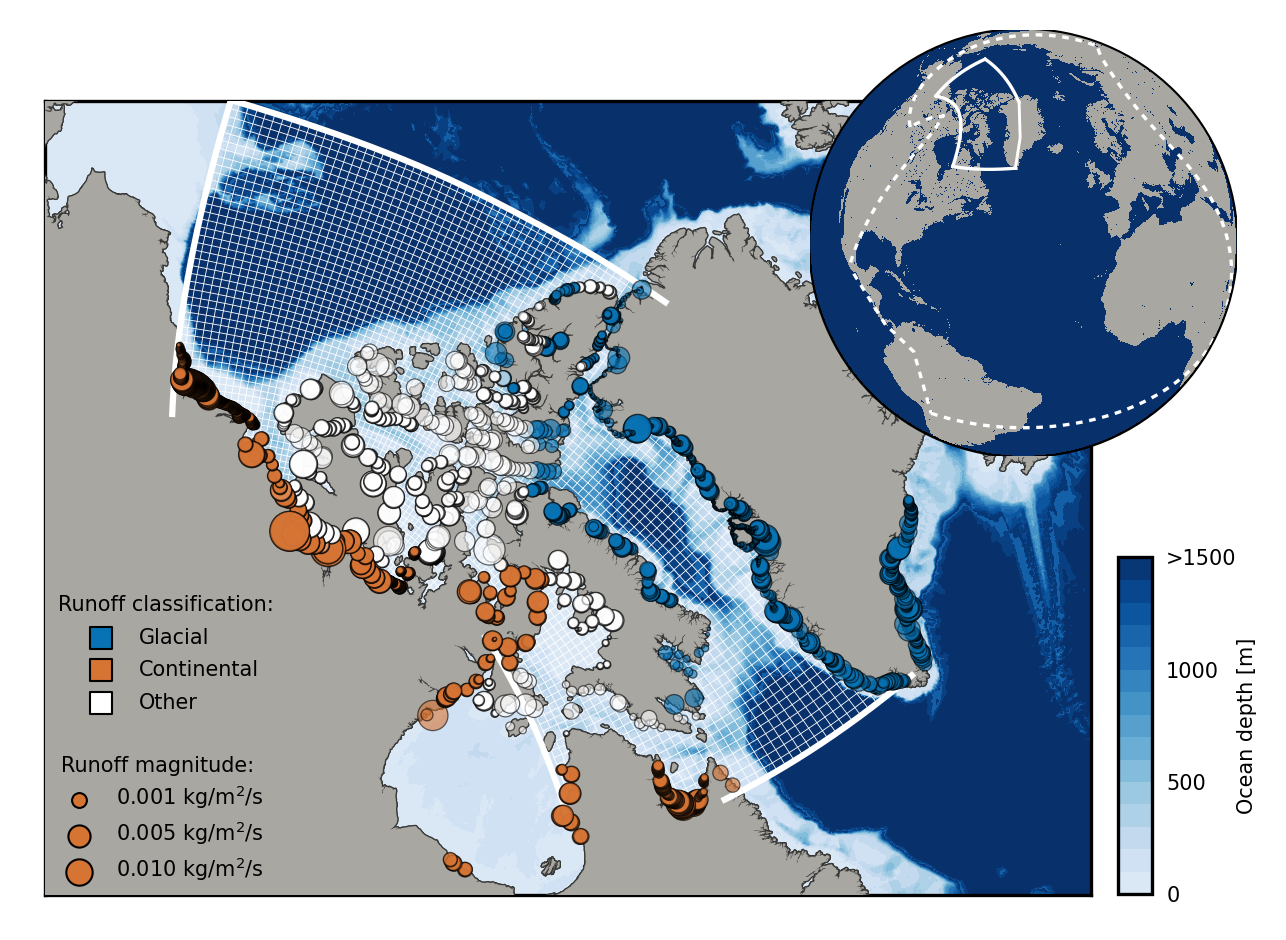

In [10]:
fig, ax1, proj1, ax2, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-map-globe.pickle','rb'))

# Globe: --------------------------------------------------------------------------------------
x, y  = proj2(mesh_lon, mesh_lat) 

# Sub-domain
proj2.plot(x[bdy_BB[0],bdy_HB[2]:bdy_BB[3]], y[bdy_BB[0],bdy_HB[2]:bdy_BB[3]], '-', c='w', lw=0.8, zorder=4); # Baffin Bay
proj2.plot(x[bdy_WCB[0],bdy_HB[2]:bdy_WCB[3]], y[bdy_WCB[0],bdy_HB[2]:bdy_WCB[3]], '-', c='w', lw=0.8, zorder=4); 
proj2.plot(x[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], y[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], '-', c='w', lw=0.8, zorder=4); 
proj2.plot(x[bdy_BB[0]:bdy_HB[1],bdy_HB[2]], y[bdy_BB[0]:bdy_HB[1],bdy_HB[2]], '-', c='w', lw=0.8, zorder=4);  # Hudson Bay
proj2.plot(x[bdy_HB[1]:bdy_WCB[0],bdy_HB[2]], y[bdy_HB[1]:bdy_WCB[0],bdy_HB[2]], '-', c='w', lw=0.8, zorder=4); # southern CAA
xline_add = [x[bdy_NCB[0],bdy_NCB[2]], x[1330,730], x[bdy_BB[0],bdy_BB[3]]]
yline_add = [y[bdy_NCB[0],bdy_NCB[2]], y[1330,730], y[bdy_BB[0],bdy_BB[3]]]
proj2.plot(xline_add, yline_add, 'w-', lw=0.7, zorder=3)

# full domain
proj2.plot(x[460:-1:grid_reso,0]  , y[460:-1:grid_reso,0]  , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
proj2.plot(x[0,370:-1:grid_reso]  , y[0,370:-1:grid_reso]  , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
proj2.plot(x[100:-1:grid_reso,-1] , y[100:-1:grid_reso,-1] , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
proj2.plot(x[-1,0:-1:grid_reso]   , y[-1,0:-1:grid_reso]   , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
xline_add = [x[500,0], x[700,70], x[1100,0], x[0,370]]
yline_add = [y[240,-1], y[85,-80], y[80,0], y[0,370]]
proj2.plot(xline_add, yline_add, 'w--', lw=0.8, zorder=3, dashes=(2, 2))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# masked areas
hdept_plot = np.ma.masked_where(hdept >1500, hdept)
bath = proj1.contourf(x_sub, y_sub, hdept_plot, 17, cmap=matplotlib.cm.get_cmap('Blues'), vmin=-200, vmax=1500, zorder=1)

# grid:
x_grid_plot = np.ma.masked_where((mesh_bathy[0,:,:] < 0.1), x_sub)
y_grid_plot = np.ma.masked_where((mesh_bathy[0,:,:] < 0.1), y_sub)
proj1.plot(x_grid_plot[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso]  , \
           y_grid_plot[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso]  , 'w-', lw=0.2, zorder=3);
proj1.plot(x_grid_plot[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso].T, \
           y_grid_plot[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso].T, 'w-', lw=0.2, zorder=3);

# River runoff:
x_rf, y_rf = proj1(model_lons, model_lats)
colormap   = matplotlib.colors.ListedColormap([color_glacier, color_continent, color_other, color_other])
proj1.scatter(x_rf[imin:imax,jmin:jmax], y_rf[imin:imax,jmin:jmax], c=river_class[imin:imax,jmin:jmax],\
              s=np.sqrt(rf[imin:imax,jmin:jmax])*4e2, alpha=0.6, cmap=colormap, edgecolor='k', linewidths=0.3, zorder=5)

proj1.drawcoastlines(color=land_outline_color, linewidth=0.6, zorder=4);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=4);

# Domain boundaries: 
proj1.plot(x_sub[bdy_BB[0],bdy_BB[2]:bdy_BB[3]], y_sub[bdy_BB[0],bdy_BB[2]:bdy_BB[3]], '-', c='w', lw=1.5, zorder=4);
proj1.plot(x_sub[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], y_sub[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], '-', c='w', lw=1.5, zorder=4); 
proj1.plot(x_sub[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], y_sub[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], '-', c='w', lw=1.5, zorder=4); 
proj1.plot(x_sub[bdy_HB[0]:bdy_HB[1],bdy_HB[2]], y_sub[bdy_HB[0]:bdy_HB[1],bdy_HB[2]], '-', c='w', lw=1.5, zorder=4); 

#--- Legend ----------------------
for a in ['0.001', '0.005', '0.010']:
    proj1.scatter([], [], c=color_continent, alpha=1, s=np.sqrt(float(a))*4e2, label=f'{a} kg/m$^2$/s', \
                  edgecolors='k', linewidths=0.5, zorder=4)

l1 = ax1.legend(scatterpoints=1, frameon=True, framealpha=0, labelspacing=0.4, fontsize=5, loc=(0.005, 0.005), \
                fancybox=False, title='Runoff magnitude: ')
l1.get_title().set_fontsize('5')
g  = proj1.scatter([], [], c=color_glacier  , alpha=1, s=30, linewidths=0.5, edgecolors='k', zorder=4, marker='s')
c  = proj1.scatter([], [], c=color_continent, alpha=1, s=30, linewidths=0.5, edgecolors='k', zorder=4, marker='s')
o  = proj1.scatter([], [], c=color_other    , alpha=1, s=30, linewidths=0.5, edgecolors='k', zorder=4, marker='s')
l2 = ax1.legend([g, c, o], ['Glacial', 'Continental', 'Other'], title='Runoff classification: ', \
                scatterpoints=1, frameon=True, labelspacing=0.6, fontsize=5, loc=(0.005, 0.22), fancybox=False, framealpha=0)
l2.get_title().set_fontsize('5')
ax1.add_artist(l1)

# Color bar: --------------------------------------------------------------------------------
cbaxes = fig.add_axes([0.92, 0.15, 0.025, 0.3]);
CBar   = plt.colorbar(bath, ax=ax1, cax=cbaxes, ticks=[0,500,1000,1500]); 
CBar.set_label('Ocean depth [m]', fontsize=5, labelpad=0)
CBar.ax.tick_params(axis='y', length=0, labelsize=5)
CBar.ax.set_yticklabels(['0','500','1000','>1500']); 

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/M1-model-domain.jpg', bbox_inches='tight', dpi=300)

In [20]:
1473-imin

334

In [47]:
# adjust masks based on where the boundary transports are calculated
# l1 = 1151-imin; l2 = 2168-imin;
# r1 = 0; r2 = 778-jmin;

# l3 = 1190-imin; l4 = 1490-imin;
# r3 = 200-jmin;  r4 = 303-jmin;

l1 = 1151-imin; l2 = 2168-imin;
r1 = 0; r2 = 777-jmin;

l3 = 0;  l4 = 1475-imin;
r3 = 0;  r4 = 304-jmin;

l5 = 0;  l6 = 230;
r5 = 510;  r6 = 700;

In [48]:
ind_array = np.zeros(mesh_lon[imin:imax,jmin:jmax].shape)
ind_array[l1:l2,r1:r2] = 1
ind_array[l3:l4,r3:r4] = 0
ind_array[l5:l6,r5:r6] = 0

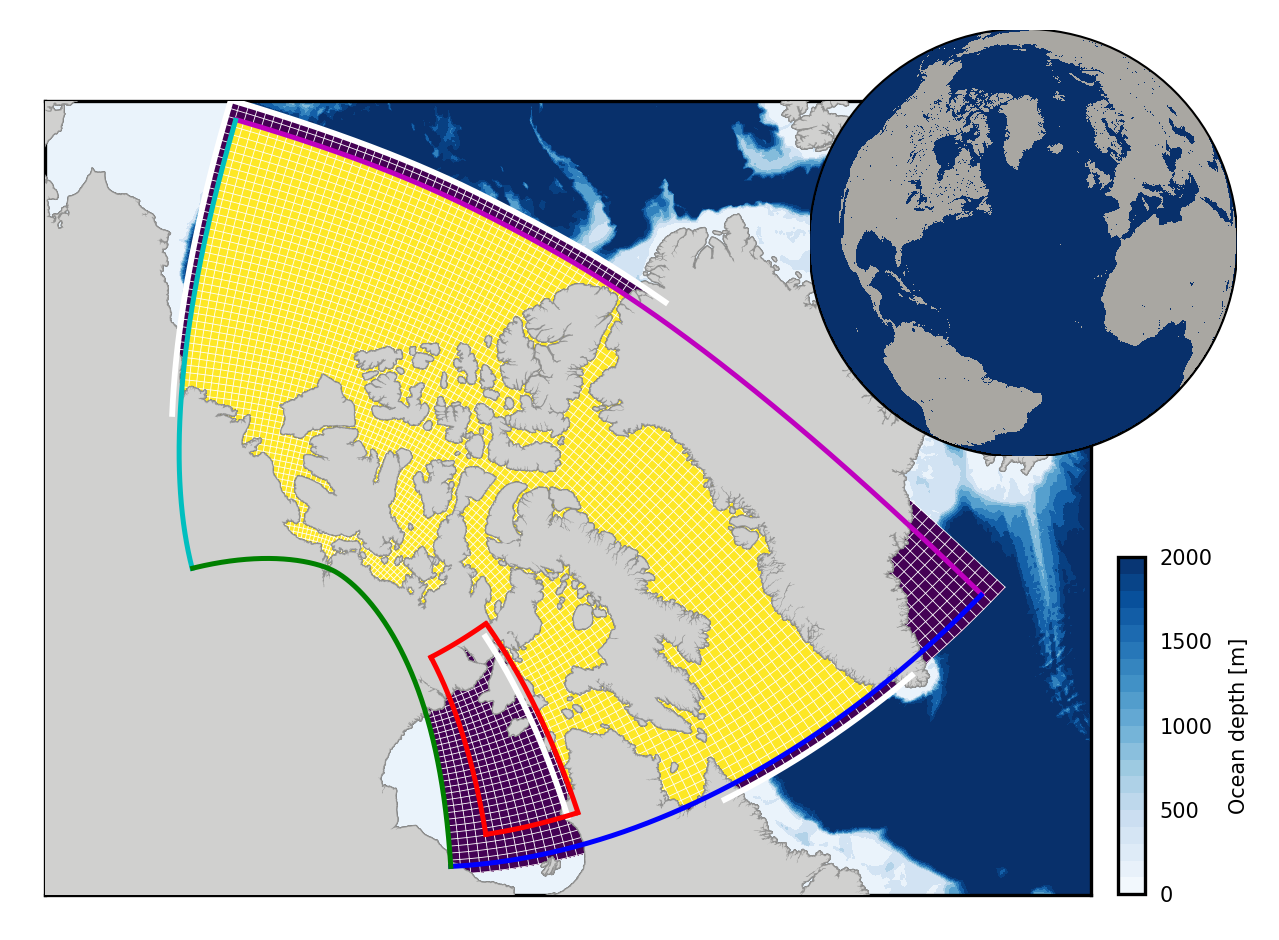

In [50]:
fig, ax1, proj1, ax2, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-map-globe.pickle','rb'))
# fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Canada-Basin.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# grid:
x_grid_plot = np.ma.masked_where((mesh_bathy[0,:,:] < 0.1), x_sub)
y_grid_plot = np.ma.masked_where((mesh_bathy[0,:,:] < 0.1), y_sub)
proj1.plot(x_sub[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso]  , \
           y_sub[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso]  , 'w-', lw=0.2, zorder=3);
proj1.plot(x_sub[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso].T, \
           y_sub[imin:imax+grid_reso:grid_reso,jmin:jmax+grid_reso:grid_reso].T, 'w-', lw=0.2, zorder=3);

proj1.drawcoastlines(color=light_land_edge, linewidth=0.6, zorder=4);
proj1.fillcontinents(color=light_land, lake_color=light_land, zorder=4);

# Domain boundaries: 
proj1.plot(x_sub[bdy_BB[0],bdy_BB[2]:bdy_BB[3]], y_sub[bdy_BB[0],bdy_BB[2]:bdy_BB[3]], '-', c='w', lw=1.4, zorder=4);
proj1.plot(x_sub[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], y_sub[bdy_WCB[0],bdy_WCB[2]:bdy_WCB[3]], '-', c='w', lw=1.4, zorder=4); 
proj1.plot(x_sub[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], y_sub[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]], '-', c='w', lw=1.4, zorder=4); 
proj1.plot(x_sub[bdy_HB[0]:bdy_HB[1],bdy_HB[2]], y_sub[bdy_HB[0]:bdy_HB[1],bdy_HB[2]], '-', c='w', lw=1.4, zorder=4); 

# l1 = 1151
# l2 = 2168
# r1 = 159
# r2 = 778
l1 = 1150
l2 = 2168
r1 = jmin
r2 = 778
kwags={'linewidth':1.2, 'zorder':4}
proj1.plot(x_sub[l1:l2,r2], y_sub[l1:l2,r2], c='m',**kwags)  #nCB
proj1.plot(x_sub[l2,r1:r2], y_sub[l2,r1:r2] , c='c',**kwags) # wCB
proj1.plot(x_sub[l1,r1:r2], y_sub[l1,r1:r2] , c='b',**kwags) # BB
proj1.plot(x_sub[l1:l2,r1], y_sub[l1:l2,r1] , c='g',**kwags) # HB

proj1.plot(x_sub[1190:1490,303], y_sub[1190:1490,303] , c='r',**kwags) # HB
proj1.plot(x_sub[1190:1490,200], y_sub[1190:1490,200] , c='r',**kwags) # HB
proj1.plot(x_sub[1190,200:303], y_sub[1190,200:303] , c='r',**kwags) # HB
proj1.plot(x_sub[1490,200:303], y_sub[1490,200:303] , c='r',**kwags) # HB

proj1.pcolormesh(x_sub[imin:imax,jmin:jmax], y_sub[imin:imax,jmin:jmax], ind_array)

# Color bar: --------------------------------------------------------------------------------
cbaxes = fig.add_axes([0.92, 0.15, 0.02, 0.3]);
CBar   = plt.colorbar(bath, ax=ax1, cax=cbaxes, ticks=[0,500,1000,1500,2000]); 
CBar.set_label('Ocean depth [m]', fontsize=5)
CBar.ax.tick_params(axis='y', length=0, labelsize=5)